# Notebook to load examples from the test set over MVD dataset

### Imports and setup

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import time
from os import listdir
from os.path import isfile, join
from src import data, evaluate, model, preprocessing, visualization
from src.lib import utils
from src.data import MontevideoFoldersDataset, MontevideoFoldersDataset_w_time, MontevideoFoldersDataset_w_CMV

#Deep Learning
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn

import random
from src.dl_models.unet import UNet, UNet2
from src.lib.latex_options import Colors, Linestyles

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

dataset = 'mvd'

time_horizon = 30

In [3]:
def show_seq_and_pred(sequence_array, time_list, prediction_t, fig_name=None, grid=True):
    """ Shows the images passed in a grid
    Args:
        sequence_array (array)
    """
    nbof_frames = sequence_array.shape[0]
    if np.max(sequence_array[0]) > 1.1:
        vmax = 100
    else:
        vmax = 1
    
    fontsize = 22 # 22 generates the font more like the latex text
    
    # plt.figure(figsize=(25, 5))
    fig, ax = plt.subplots(1, nbof_frames, figsize=(6 * nbof_frames, 5))

    
    for i in range(nbof_frames):
        if i < nbof_frames - 2:
            ax[i].imshow(sequence_array[i], vmin=0, vmax=vmax)
            input_nbr = i - (nbof_frames - 3)
            ax[i].set_title(f'{time_list[i]}')
            ax[i].grid(grid)


        if i == nbof_frames - 2:
            im = ax[i].imshow(sequence_array[i], vmin=0, vmax=vmax)
            cbar = plt.colorbar(im, ax=ax[i], fraction=0.046, pad=0.04)
            ax[i].set_title(f'{time_list[-1]}')
            ax[i].grid(grid)

        if i == nbof_frames - 1:
            im = ax[i].imshow(sequence_array[i], vmin=0, vmax=vmax)
            cbar = plt.colorbar(im, ax=ax[i], fraction=0.046, pad=0.04)
            ax[i].set_title(f'{time_list[-1]}')
            ax[i].grid(grid)

        if nbof_frames == 6:
            line = plt.Line2D((.643, .643),(.1, 1), linewidth=3)
        elif nbof_frames == 5:
            line = plt.Line2D((.59, .59),(.1, 1), linewidth=3)
        else:
            line = plt.Line2D((.515, .515),(.1, 1), linewidth=3)
        fig.add_artist(line)

    plt.show()

### Models loading

In [4]:
# Unet ====================================================================
root_path = '/clusteruy/home03/DeepCloud/deepCloud/checkpoints/MVD/'

if time_horizon == 60:
    unet16 = '60min/60min_UNET2_mvd_mae_filters16_sigmoid_diffFalse_retrainFalse_15_17-02-2022_11:13_BEST_FINAL.pt'
elif time_horizon == 30:
    unet16 = '30min/30min_UNET2_mvd_mae_filters16_sigmoid_diffFalse_retrainFalse_34_16-02-2022_11:26_BEST_FINAL.pt'
else:
    unet16 = '90min/90min_UNET2_mvd_mae_filters16_sigmoid_diffFalse_retrainFalse_16_17-02-2022_06:27_BEST_FINAL.pt'
    
unet16_path = os.path.join(root_path, unet16)


OUTPUT_ACTIVATION = 'sigmoid'    

unet16 = UNet2(n_channels=3,n_classes=1, bilinear=True, p=0,
              output_activation=OUTPUT_ACTIVATION, bias=False, filters=16).to(device)
unet16.load_state_dict(torch.load(unet16_path, map_location=torch.device('cpu'))["model_state_dict"])
unet16.eval()

# wGAN ====================================================================
wgan64_path = f'/clusteruy/home/franco.mozo/deepCloud/checkpoints/GAN_FINAL_MODELS/wgan_64fil_20eps_ph{time_horizon}min.pt'

wgan_gen = UNet2(n_channels=3, n_classes=1, bilinear=True, bias=False, filters=64).to(device)
wgan_gen.load_state_dict(torch.load(wgan64_path, map_location=torch.device('cpu'))["model_state_dict"])
wgan_gen.eval()


# U-Net InputCMV
if time_horizon == 30:
    inputCMV_path = '30min/30min_UNET2_inputCMV_mvd_mae_filters16_sigmoid_diffFalse_retrainFalse_26_07-03-2022_23:21_BEST_FINAL.pt'
elif time_horizon == 60:
    inputCMV_path = '60min/60min_UNET2_inputCMV_mvd_mae_filters16_sigmoid_diffFalse_retrainFalse_20_06-03-2022_21:51_BEST_FINAL.pt'
else:
    inputCMV_path = '90min/90min_UNET2_inputCMV_mvd_mae_filters16_sigmoid_diffFalse_retrainFalse_18_06-03-2022_21:44_BEST_FINAL.pt'
inputCMV_path = os.path.join(root_path, inputCMV_path)

unet_inputCMV = UNet2(n_channels=4, n_classes=1, bilinear=True, p=0,
                      output_activation='sigmoid', bias=False, filters=16).to(device)
unet_inputCMV.load_state_dict(torch.load(inputCMV_path, map_location=torch.device('cpu'))["model_state_dict"])
unet_inputCMV.eval()

print('Done.')

Done.


In [5]:
#class to group two datasets
class MyDataset(Dataset):
    def __init__(self, datasetA, datasetB):
        self.datasetA = datasetA
        self.datasetB = datasetB
        
    def __getitem__(self, index):
        xA = self.datasetA[index]
        xB = self.datasetB[index]
        return xA, xB
    
    def __len__(self):
        return len(self.datasetA)

In [6]:
CSV_PATH = '/clusteruy/home03/DeepCloud/deepCloud/data/mvd/test_cosangs_mvd.csv' # '/clusteruy/home03/DeepCloud/deepCloud/data/region3/test_cosangs_region3.csv'
normalize = preprocessing.normalize_pixels(mean0 = False) #values between [0,1]
FRAME_OUT = int(time_horizon/10)
OUTPUT_LAST = True

test_mvd = MontevideoFoldersDataset_w_time(
                path='/clusteruy/home03/DeepCloud/deepCloud/data/' + dataset + '/test/',
                in_channel=3,
                out_channel=FRAME_OUT,
                min_time_diff=5,
                max_time_diff=15,
                csv_path=CSV_PATH,
                transform=normalize,
                output_last=OUTPUT_LAST
)

test_mvd_CMV = MontevideoFoldersDataset_w_CMV(
                                path='/clusteruy/home03/DeepCloud/deepCloud/data/' + dataset + '/test/',  
                                cmv_path=f"/clusteruy/home03/DeepCloud/deepCloud/data/cmv/cmv_{dataset}_{time_horizon}min/test/",
                                in_channel=3, out_channel=FRAME_OUT,
                                min_time_diff=5, max_time_diff=15,
                                csv_path=CSV_PATH,
                                transform = normalize, output_last=OUTPUT_LAST,
                                day_pct=1)
  
test_mvd_datasets = MyDataset(test_mvd, test_mvd_CMV)
loader = DataLoader(test_mvd_datasets, batch_size=1, shuffle=True)
iterator = iter(loader)

torch.Size([1, 3, 256, 256]) torch.Size([1, 1, 256, 256])
torch.Size([1, 4, 256, 256]) torch.Size([1, 1, 256, 256])
Prediction horizon: 30
Day: 195
Model: U-Net


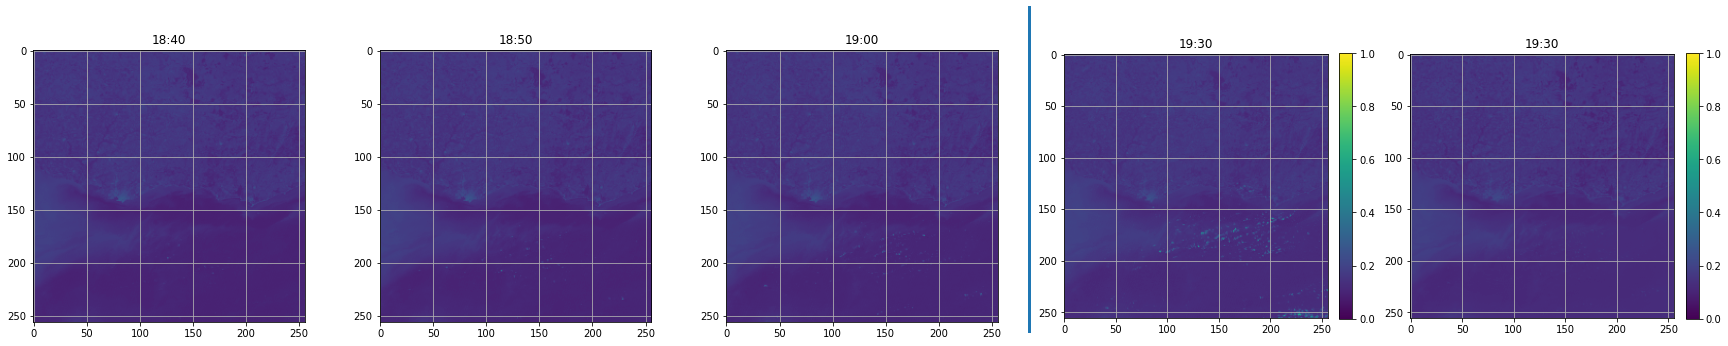

Model: wGAN


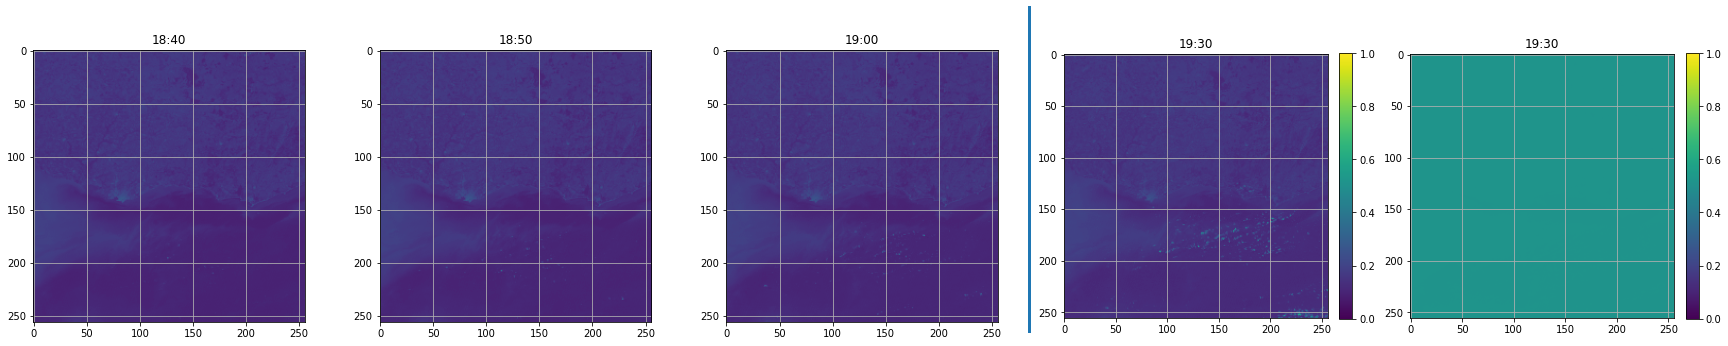

Model: U-Net InputCMV


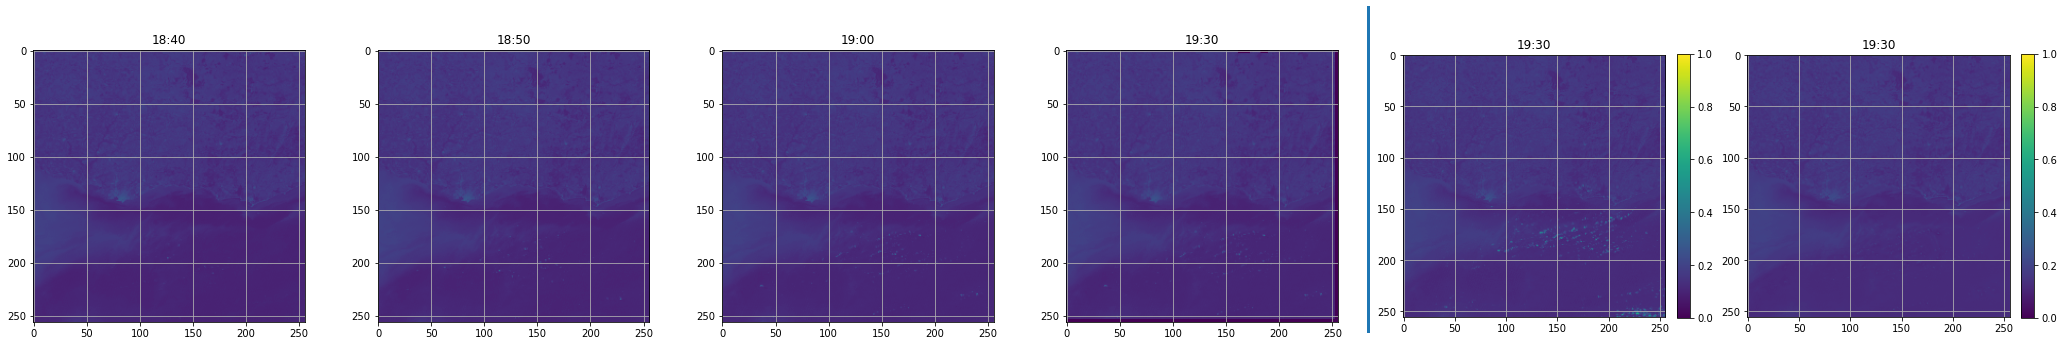

In [7]:
data_multiple_datasets = next(iterator)
in_frames, out_frames, in_time, out_time = data_multiple_datasets[0]
print(in_frames.shape, out_frames.shape)

in_frames_cmv, out_frames_cmv = data_multiple_datasets[1]
print(in_frames_cmv.shape, out_frames_cmv.shape)
timestamp = out_time[0, 0]

with torch.no_grad():
    in_frames = in_frames.to(device=device)
    out_frames = out_frames.to(device=device)
    in_frames_cmv = in_frames_cmv.to(device=device)
    out_frames_cmv = out_frames_cmv.to(device=device)
    
    frames_pred_unet16 = unet16(in_frames)
    frames_pred_wgan_gen = wgan_gen(in_frames)
    frames_pred_inputCMV = unet_inputCMV(in_frames_cmv)

    
in_time = in_time[0].numpy()
print(f'Prediction horizon: {time_horizon}')
print('Day:', int(in_time[0,0]))

t_6 = str(int(timestamp[1].numpy())).zfill(2) + ':' + str(int(timestamp[2].numpy())).zfill(2)
t__2 = str(int((in_time[0][1]))).zfill(2) + ':' + str(int((in_time[0][2]))).zfill(2)
t__1 = str(int((in_time[1][1]))).zfill(2) + ':' + str(int((in_time[1][2]))).zfill(2)
t_0 = str(int((in_time[2][1]))).zfill(2) + ':' + str(int((in_time[2][2]))).zfill(2)

time_list = [t__2, t__1, t_0, t_6]

print(f'Model: U-Net')
sequence_array_60 = np.array([
            in_frames[0][0].cpu().numpy(),
            in_frames[0][1].cpu().numpy(),
            in_frames[0][2].cpu().numpy(),
            out_frames[0][0].cpu().numpy(),
            frames_pred_unet16[0, 0].cpu().numpy()
])
show_seq_and_pred(sequence_array_60,
                  time_list=time_list,
                  prediction_t=3,
                  fig_name=None,
                  grid=True
                 )

print(f'Model: wGAN')
sequence_array_60 = np.array([
            in_frames[0][0].cpu().numpy(),
            in_frames[0][1].cpu().numpy(),
            in_frames[0][2].cpu().numpy(),
            out_frames[0][0].cpu().numpy(),
            frames_pred_wgan_gen[0, 0].cpu().numpy()
])
show_seq_and_pred(sequence_array_60,
                  time_list=time_list,
                  prediction_t=3,
                  fig_name=None,
                  grid=True
                 )

print(f'Model: U-Net InputCMV')
sequence_array_60 = np.array([
            in_frames_cmv[0][0].cpu().numpy(),
            in_frames_cmv[0][1].cpu().numpy(),
            in_frames_cmv[0][2].cpu().numpy(),
            in_frames_cmv[0][3].cpu().numpy(),
            out_frames_cmv[0][0].cpu().numpy(),
            frames_pred_inputCMV[0, 0].cpu().numpy()
])
show_seq_and_pred(sequence_array_60,
                  time_list=time_list,
                  prediction_t=3,
                  fig_name=None,
                  grid=True,
                 )